In [4]:
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ─── Constants ────────────────────────────────────────────────────────────────
STEGO_CSV   = Path("csv/stego_final.csv")
IMAGES_DIR  = Path("Images")
BATCH_SIZE  = 32
EPOCHS      = 20
LR          = 5e-4
RANDOM_SEED = 42
NUM_CLASSES = 2
DEVICE="cpu"
# ─── Reproducibility ─────────────────────────────────────────────────────────
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ─── 1) Prepare DataFrame (as you already have) ───────────────────────────────
df_stego = pd.read_csv(STEGO_CSV)
df_stego = df_stego[df_stego.method.isin(["lsb", "iwt"])].copy()
df_stego["binary_method"] = "stego"
df_stego["img_path"]      = df_stego["stego_path"]

n_stego     = len(df_stego)
all_images  = list(IMAGES_DIR.glob("*"))
used_names  = set(Path(p).name for p in df_stego["img_path"])
candidates  = [str(p) for p in all_images if p.name not in used_names]
none_samples= random.sample(candidates, min(n_stego, len(candidates)))

df_none = pd.DataFrame({
    "binary_method": ["none"] * len(none_samples),
    "img_path":      none_samples
})

df = pd.concat([df_stego[["binary_method","img_path"]], df_none],
               ignore_index=True)
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Encode labels
label_map = {"none": 0, "stego": 1}
df["label"] = df["binary_method"].map(label_map)

# ─── 2) Stratified split ──────────────────────────────────────────────────────
df_train, df_test = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=RANDOM_SEED
)
df_train, df_val  = train_test_split(
    df_train, test_size=0.30, stratify=df_train["label"], random_state=RANDOM_SEED
)

# ─── 3) Dataset and Transforms ─────────────────────────────────────────────────
class StegoDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = row["label"]
        return img, label

# ImageNet-style preprocessing
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_ds = StegoDataset(df_train, transform=train_tf)
val_ds   = StegoDataset(df_val,   transform=eval_tf)
test_ds  = StegoDataset(df_test,  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



In [8]:
# ─── 4) Model, Loss, Optimizer ─────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
# Replace final fully-connected layer
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# ─── 5) Training & Evaluation Loops ───────────────────────────────────────────
def train_epoch(loader):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss      += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc


def eval_epoch(loader):
    model.eval()
    loss, corrects = 0.0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval ", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss += criterion(outputs, labels).item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            corrects += (preds == labels).sum().item()
    return loss / len(loader.dataset), corrects / len(loader.dataset)

# ─── Prepare metric containers ─────────────────────────────────────────────────
train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

best_val_acc = 0.0

# ─── Training + Validation Loop ────────────────────────────────────────────────
for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    model.train()
    running_loss, running_corrects = 0.0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} — Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss      += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc  = running_corrects / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # --- Validate ---
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} — Val  ", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss      += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()

    epoch_val_loss = running_loss / len(val_loader.dataset)
    epoch_val_acc  = running_corrects / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    # Step the scheduler
    scheduler.step()

    print(f"Epoch {epoch:2d}/{EPOCHS}  "
          f"Train Loss: {epoch_train_loss:.4f}  Train Acc: {epoch_train_acc:.4f}  "
          f"Val   Loss: {epoch_val_loss:.4f}  Val   Acc: {epoch_val_acc:.4f}")

    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_resnet50_none.pth")

# ─── 6) Final Test Accuracy ───────────────────────────────────────────────────
test_loss, test_acc = eval_epoch(test_loader)
print(f"\nTest Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")


/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch  1/20  Train Loss: 0.5771  Train Acc: 0.6787  Val   Loss: 1.1992  Val   Acc: 0.6888


Epoch  2/20  Train Loss: 0.5683  Train Acc: 0.6835  Val   Loss: 0.5110  Val   Acc: 0.7353


Epoch  3/20  Train Loss: 0.5417  Train Acc: 0.7121  Val   Loss: 0.5051  Val   Acc: 0.7440


Epoch  4/20  Train Loss: 0.5121  Train Acc: 0.7336  Val   Loss: 0.5893  Val   Acc: 0.6964


Epoch  5/20  Train Loss: 0.5463  Train Acc: 0.7217  Val   Loss: 0.5445  Val   Acc: 0.7102


Epoch  6/20  Train Loss: 0.5285  Train Acc: 0.7137  Val   Loss: 0.6167  Val   Acc: 0.7428


Epoch  7/20  Train Loss: 0.5157  Train Acc: 0.7250  Val   Loss: 0.6064  Val   Acc: 0.7365


Epoch  8/20  Train Loss: 0.5007  Train Acc: 0.7417  Val   Loss: 0.5153  Val   Acc: 0.7277


Epoch  9/20  Train Loss: 0.4948  Train Acc: 0.7325  Val   Loss: 0.5843  Val   Acc: 0.7240


Epoch 10/20  Train Loss: 0.5020  Train Acc: 0.7325  Val   Loss: 0.5430  Val   Acc: 0.7428


Epoch 11/20  Train Loss: 0.4982  Train Acc: 0.7347  Val   Loss: 0.6098  Val   Acc: 0.7403


Epoch 12/20  Train Loss: 0.5012  Train Acc: 0.7320  Val   Loss: 0.5206  Val   Acc: 0.7415


Epoch 13/20  Train Loss: 0.4953  Train Acc: 0.7352  Val   Loss: 0.5099  Val   Acc: 0.7340


Epoch 14/20  Train Loss: 0.4957  Train Acc: 0.7341  Val   Loss: 0.5143  Val   Acc: 0.7353


Epoch 15/20  Train Loss: 0.4924  Train Acc: 0.7352  Val   Loss: 0.5115  Val   Acc: 0.7365


Epoch 16/20  Train Loss: 0.4904  Train Acc: 0.7341  Val   Loss: 0.5121  Val   Acc: 0.7365


Epoch 17/20  Train Loss: 0.4908  Train Acc: 0.7411  Val   Loss: 0.5303  Val   Acc: 0.7353


Epoch 18/20  Train Loss: 0.4924  Train Acc: 0.7411  Val   Loss: 0.5070  Val   Acc: 0.7353


Epoch 19/20  Train Loss: 0.4913  Train Acc: 0.7406  Val   Loss: 0.5080  Val   Acc: 0.7365


Epoch 20/20  Train Loss: 0.4894  Train Acc: 0.7384  Val   Loss: 0.5147  Val   Acc: 0.7353



Test Loss: 0.5456  Test Acc: 0.7243


In [28]:
from torch.utils.data import WeightedRandomSampler

# ─── 4) Model, Loss, Optimizer ─────────────────────────────────────────────────
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = models.resnet50(pretrained=True)
in_feats  = model.fc.in_features
model.fc  = nn.Linear(in_feats, NUM_CLASSES)
model     = model.to(device)

# give more weight to none in the loss if you like (optional)
class_weights = torch.tensor([2.0, 1.0], device=device)  # double weight on “none”
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# ─── 4.1) Build a sampler that upsamples “none” (label=0) twice as often ───────
train_labels = df_train["label"].values
sample_weights = np.array([2.0 if l==0 else 1.0 for l in train_labels])
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=4
)

# leave val_loader and test_loader unchanged

# ─── 5) Training & Evaluation Loops ───────────────────────────────────────────
def train_epoch(loader):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss      += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()

    return running_loss / len(loader.dataset), running_corrects / len(loader.dataset)


def eval_epoch(loader):
    model.eval()
    loss, corrects = 0.0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Eval ", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss += criterion(outputs, labels).item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            corrects += (preds == labels).sum().item()
    return loss / len(loader.dataset), corrects / len(loader.dataset)


# ─── 5.1) Prepare metric containers ────────────────────────────────────────────
train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []
best_val_acc = 0.0

# ─── 5.2) Training + Validation Loop ───────────────────────────────────────────
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_epoch(train_loader)
    vl, va = eval_epoch(val_loader)
    scheduler.step()

    train_losses.append(tl)
    train_accs.append(ta)
    val_losses.append(vl)
    val_accs.append(va)

    print(f"Epoch {epoch:2d}/{EPOCHS}  "
          f"Train Loss: {tl:.4f}  Train Acc: {ta:.4f}  "
          f"Val   Loss: {vl:.4f}  Val   Acc: {va:.4f}")

    if va > best_val_acc:
        best_val_acc = va
        torch.save(model.state_dict(), "best_resnet50_none.pth")

# ─── 6) Final Test Accuracy ───────────────────────────────────────────────────
model.load_state_dict(torch.load("best_resnet50_none.pth"))
test_loss, test_acc = eval_epoch(test_loader)
print(f"\nTest Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")


Epoch  1/20  Train Loss: 0.4291  Train Acc: 0.7863  Val   Loss: 0.5357  Val   Acc: 0.7327


Epoch  2/20  Train Loss: 0.4045  Train Acc: 0.7928  Val   Loss: 0.4539  Val   Acc: 0.7428


Epoch  3/20  Train Loss: 0.3524  Train Acc: 0.8143  Val   Loss: 0.5003  Val   Acc: 0.7127


Epoch  4/20  Train Loss: 0.3402  Train Acc: 0.8283  Val   Loss: 0.5094  Val   Acc: 0.7227


Epoch  5/20  Train Loss: 0.3554  Train Acc: 0.8111  Val   Loss: 0.5154  Val   Acc: 0.7340


Epoch  6/20  Train Loss: 0.4016  Train Acc: 0.7901  Val   Loss: 0.6440  Val   Acc: 0.5809


Epoch  7/20  Train Loss: 0.3609  Train Acc: 0.8062  Val   Loss: 0.5413  Val   Acc: 0.7265


Epoch  8/20  Train Loss: 0.3511  Train Acc: 0.8245  Val   Loss: 0.4885  Val   Acc: 0.7403


Epoch  9/20  Train Loss: 0.3401  Train Acc: 0.8208  Val   Loss: 0.4954  Val   Acc: 0.7415


Epoch 10/20  Train Loss: 0.3438  Train Acc: 0.8138  Val   Loss: 0.4756  Val   Acc: 0.7403


Epoch 11/20  Train Loss: 0.3475  Train Acc: 0.8159  Val   Loss: 0.4856  Val   Acc: 0.7415


Epoch 12/20  Train Loss: 0.3546  Train Acc: 0.8143  Val   Loss: 0.4677  Val   Acc: 0.7403


Epoch 13/20  Train Loss: 0.3218  Train Acc: 0.8321  Val   Loss: 0.4918  Val   Acc: 0.7428


Epoch 14/20  Train Loss: 0.3447  Train Acc: 0.8202  Val   Loss: 0.4894  Val   Acc: 0.7415


Epoch 15/20  Train Loss: 0.3492  Train Acc: 0.8208  Val   Loss: 0.4854  Val   Acc: 0.7403


Epoch 16/20  Train Loss: 0.3213  Train Acc: 0.8348  Val   Loss: 0.4982  Val   Acc: 0.7415


Epoch 17/20  Train Loss: 0.3220  Train Acc: 0.8342  Val   Loss: 0.4901  Val   Acc: 0.7415


Epoch 18/20  Train Loss: 0.3451  Train Acc: 0.8165  Val   Loss: 0.4838  Val   Acc: 0.7428


Epoch 19/20  Train Loss: 0.3335  Train Acc: 0.8235  Val   Loss: 0.4855  Val   Acc: 0.7428


Epoch 20/20  Train Loss: 0.3346  Train Acc: 0.8235  Val   Loss: 0.4827  Val   Acc: 0.7428


FileNotFoundError: [Errno 2] No such file or directory: 'best_resnet50_none2.pth'

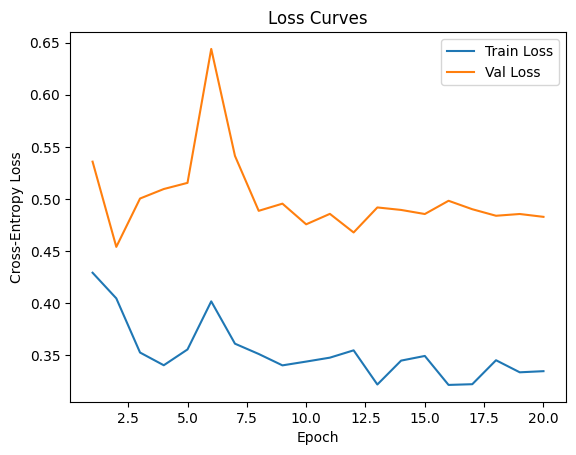

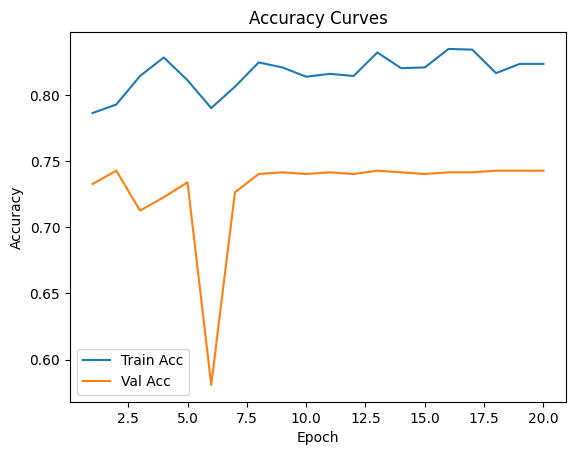

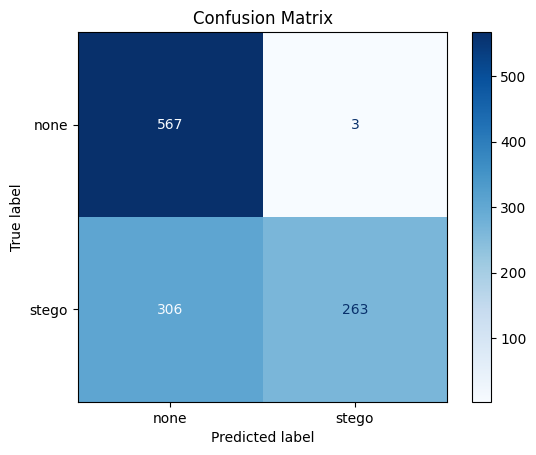

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Loss curves
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses,    label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses,      label="Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.show()

# 2) Accuracy curves (optional)
plt.figure()
plt.plot(range(1, EPOCHS+1), train_accs,      label="Train Acc")
plt.plot(range(1, EPOCHS+1), val_accs,        label="Val Acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 3) Confusion matrix on TEST set
#    (you can also do this on validation instead)
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 2. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['none','stego'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()




In [1]:
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ─── Constants ────────────────────────────────────────────────────────────────
STEGO_CSV   = Path("csv/stego_final.csv")
IMAGES_DIR  = Path("Images")
BATCH_SIZE  = 32
EPOCHS      = 20
LR          = 5e-4
RANDOM_SEED = 42
NUM_CLASSES = 2
BATCH_LOG_INTERVAL = 20  # print a batch‐loss every 20 mini‐batches

# ─── Reproducibility ─────────────────────────────────────────────────────────
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ─── 1) Prepare DataFrame ─────────────────────────────────────────────────────
df_stego = pd.read_csv(STEGO_CSV)
df_stego = df_stego[df_stego.method.isin(["lsb", "iwt"])].copy()
df_stego["binary_method"] = "stego"
df_stego["img_path"]      = df_stego["stego_path"]

n_stego     = len(df_stego)
all_images  = list(IMAGES_DIR.glob("*"))
used_names  = set(Path(p).name for p in df_stego["img_path"])
candidates  = [str(p) for p in all_images if p.name not in used_names]
none_samples= random.sample(candidates, min(n_stego, len(candidates)))

df_none = pd.DataFrame({
    "binary_method": ["none"] * len(none_samples),
    "img_path":      none_samples
})

df = pd.concat([df_stego[["binary_method","img_path"]], df_none],
               ignore_index=True)
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Encode labels
label_map = {"none": 0, "stego": 1}
df["label"] = df["binary_method"].map(label_map)

# ─── 2) Stratified split ──────────────────────────────────────────────────────
df_train, df_test = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=RANDOM_SEED
)
df_train, df_val  = train_test_split(
    df_train, test_size=0.30, stratify=df_train["label"], random_state=RANDOM_SEED
)

# ─── 3) Dataset and (Tamed) Transforms ─────────────────────────────────────────
class StegoDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, row["label"]

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.3),  # less aggressive
    # transforms.ColorJitter(brightness=0.1, contrast=0.1),  # optional mild jitter
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std= [0.229, 0.224, 0.225]
    ),
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std= [0.229, 0.224, 0.225]
    ),
])

train_ds = StegoDataset(df_train, transform=train_tf)
val_ds   = StegoDataset(df_val,   transform=eval_tf)
test_ds  = StegoDataset(df_test,  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ─── 4) Model, Loss, Optimizer, Scheduler ─────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)




/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# ─── 5) Training Loop with Per‐Batch Logging ──────────────────────────────────
train_losses, val_losses = [], []
train_accs,  val_accs   = [], []
best_val_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    running_loss, running_corrects = 0.0, 0
    for batch_idx, (imgs, labels) in enumerate(train_loader, 1):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate for epoch stats
        running_loss      += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()

        # per‐batch logging
        if batch_idx % BATCH_LOG_INTERVAL == 0:
            print(f"Epoch {epoch}/{EPOCHS}  Batch {batch_idx}/{len(train_loader)}  "
                  f"Batch Loss: {loss.item():.4f}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc  = running_corrects / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # ---- Validate ----
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss      += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()

    epoch_val_loss = running_loss / len(val_loader.dataset)
    epoch_val_acc  = running_corrects / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    scheduler.step()

    print(f"Epoch {epoch}/{EPOCHS}  "
          f"Train Loss: {epoch_train_loss:.4f}  Train Acc: {epoch_train_acc:.4f}  "
          f"Val   Loss: {epoch_val_loss:.4f}  Val   Acc: {epoch_val_acc:.4f}")

    # save best
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_resnet50_stego.pth")

# ─── 6) (Optional) Final Test Evaluation ──────────────────────────────────────
model.load_state_dict(torch.load("best_resnet50_stego.pth"))
model.eval()
test_loss, test_corrects = 0.0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss     += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        test_corrects += (preds == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_acc  = test_corrects / len(test_loader.dataset)
print(f"\nTest Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")

Epoch 1/20  Batch 20/59  Batch Loss: 0.7049
Epoch 1/20  Batch 40/59  Batch Loss: 0.5045
Epoch 1/20  Train Loss: 0.5696  Train Acc: 0.6954  Val   Loss: 4.0051  Val   Acc: 0.6424
Epoch 2/20  Batch 20/59  Batch Loss: 0.6639
Epoch 2/20  Batch 40/59  Batch Loss: 0.5452
Epoch 2/20  Train Loss: 0.5733  Train Acc: 0.7008  Val   Loss: 0.5328  Val   Acc: 0.7139
Epoch 3/20  Batch 20/59  Batch Loss: 0.7174
Epoch 3/20  Batch 40/59  Batch Loss: 0.5176
Epoch 3/20  Train Loss: 0.5193  Train Acc: 0.7191  Val   Loss: 0.4974  Val   Acc: 0.7415
Epoch 4/20  Batch 20/59  Batch Loss: 0.6127
Epoch 4/20  Batch 40/59  Batch Loss: 0.5285
Epoch 4/20  Train Loss: 0.5090  Train Acc: 0.7314  Val   Loss: 0.5700  Val   Acc: 0.6901
Epoch 5/20  Batch 20/59  Batch Loss: 0.5101
Epoch 5/20  Batch 40/59  Batch Loss: 0.6596
Epoch 5/20  Train Loss: 0.6164  Train Acc: 0.6593  Val   Loss: 0.6428  Val   Acc: 0.6625
Epoch 6/20  Batch 20/59  Batch Loss: 0.5391
Epoch 6/20  Batch 40/59  Batch Loss: 0.4664
Epoch 6/20  Train Loss: 0.5

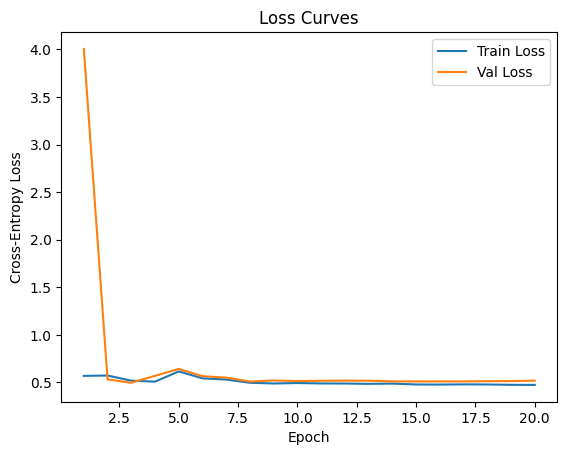

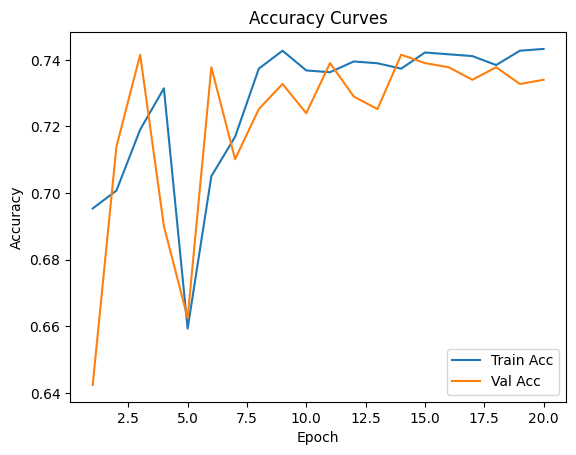

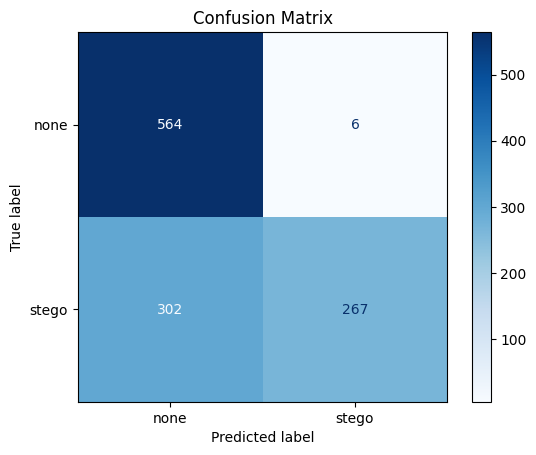

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Loss curves
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses,    label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses,      label="Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.show()

# 2) Accuracy curves (optional)
plt.figure()
plt.plot(range(1, EPOCHS+1), train_accs,      label="Train Acc")
plt.plot(range(1, EPOCHS+1), val_accs,        label="Val Acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 3) Confusion matrix on TEST set
#    (you can also do this on validation instead)
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 2. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['none','stego'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()




/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20  Batch 20/59  Loss: 0.4880
Epoch 1/20  Batch 40/59  Loss: 0.5045
Epoch 1/20  Train Loss: 0.5057  Train Acc: 0.7250  Val   Loss: 0.5852  Val   Acc: 0.6324
Epoch 2/20  Batch 20/59  Loss: 0.4127
Epoch 2/20  Batch 40/59  Loss: 0.4651
Epoch 2/20  Train Loss: 0.4351  Train Acc: 0.7702  Val   Loss: 0.7087  Val   Acc: 0.5797
Epoch 3/20  Batch 20/59  Loss: 0.4363
Epoch 3/20  Batch 40/59  Loss: 0.4760
Epoch 3/20  Train Loss: 0.3900  Train Acc: 0.8084  Val   Loss: 0.7681  Val   Acc: 0.6136
Epoch 4/20  Batch 20/59  Loss: 0.3975
Epoch 4/20  Batch 40/59  Loss: 0.3292
Epoch 4/20  Train Loss: 0.3940  Train Acc: 0.8014  Val   Loss: 0.7377  Val   Acc: 0.6186
Epoch 5/20  Batch 20/59  Loss: 0.5533
Epoch 5/20  Batch 40/59  Loss: 0.4652
Epoch 5/20  Train Loss: 0.3816  Train Acc: 0.8089  Val   Loss: 0.7700  Val   Acc: 0.6085
Epoch 6/20  Batch 20/59  Loss: 0.3306
Epoch 6/20  Batch 40/59  Loss: 0.2652
Epoch 6/20  Train Loss: 0.3507  Train Acc: 0.8321  Val   Loss: 0.8272  Val   Acc: 0.6023
Epoch 7/20

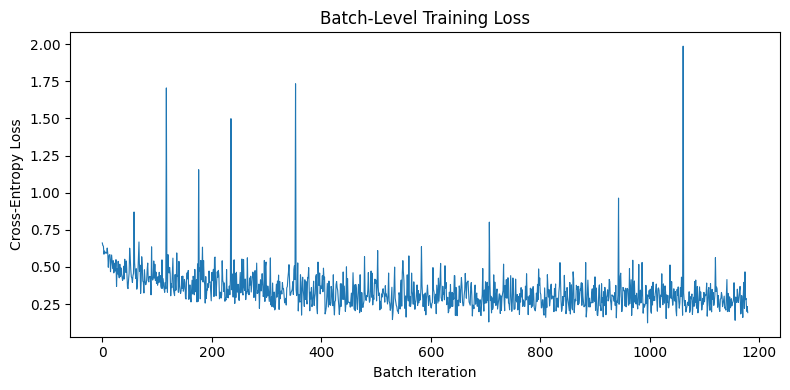

In [4]:
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# ─── Constants ────────────────────────────────────────────────────────────────
STEGO_CSV         = Path("csv/stego_final.csv")
IMAGES_DIR        = Path("Images")
BATCH_SIZE        = 32
EPOCHS            = 20
LR                = 0.000025
WEIGHT_DECAY      = 0.0005  # L2 regularization strength
RANDOM_SEED       = 42
NUM_CLASSES       = 2
BATCH_LOG_INTERVAL= 20     # print every 20 mini‐batches

# ─── Reproducibility ─────────────────────────────────────────────────────────
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# ─── 1) Prepare DataFrame ─────────────────────────────────────────────────────
df_stego = pd.read_csv(STEGO_CSV)
df_stego = df_stego[df_stego.method.isin(["lsb", "iwt"])].copy()
df_stego["binary_method"] = "stego"
df_stego["img_path"]      = df_stego["stego_path"]

n_stego     = len(df_stego)
all_images  = list(IMAGES_DIR.glob("*"))
used_names  = set(Path(p).name for p in df_stego["img_path"])
candidates  = [str(p) for p in all_images if Path(p).name not in used_names]
none_samples= random.sample(candidates, min(n_stego, len(candidates)))

df_none = pd.DataFrame({
    "binary_method": ["none"] * len(none_samples),
    "img_path":      none_samples
})

df = pd.concat([df_stego[["binary_method","img_path"]], df_none],
               ignore_index=True)
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
df["label"] = df["binary_method"].map({"none":0, "stego":1})

# ─── 2) Stratified split ──────────────────────────────────────────────────────
df_train, df_test = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=RANDOM_SEED
)
df_train, df_val  = train_test_split(
    df_train, test_size=0.30, stratify=df_train["label"], random_state=RANDOM_SEED
)

# ─── 3) Dataset & Tamed Transforms ─────────────────────────────────────────────
class StegoDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, row["label"]

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.3),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = StegoDataset(df_train, transform=train_tf)
val_ds   = StegoDataset(df_val,   transform=eval_tf)
test_ds  = StegoDataset(df_test,  transform=eval_tf)

# ─── A) Weighted sampler to up-sample 'stego' ─────────────────────────────────
train_labels   = df_train["label"].values
class_weights  = {0:1.0, 1:2.0}
sample_weights = np.array([class_weights[l] for l in train_labels])
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4)

# ─── 4) Model, Loss, Optimizer (+ weight_decay), Scheduler ──────────────────
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = models.resnet50(pretrained=True)
in_feats  = model.fc.in_features
model.fc  = nn.Linear(in_feats, NUM_CLASSES)
model     = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),
                 lr=LR,
                 weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# ─── 5) Train Loop w/ Batch-Level Logging ────────────────────────────────────
batch_losses = []
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    # — Train —
    model.train()
    running_loss, running_corrects = 0.0, 0
    for batch_idx, (imgs, labels) in enumerate(train_loader, 1):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss      += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()

        batch_losses.append(loss.item())
        if batch_idx % BATCH_LOG_INTERVAL == 0:
            print(f"Epoch {epoch}/{EPOCHS}  "
                  f"Batch {batch_idx}/{len(train_loader)}  "
                  f"Loss: {loss.item():.4f}")

    # — Validate —
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            val_loss      += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_corrects += (preds == labels).sum().item()

    train_l = running_loss / len(train_loader.dataset)
    train_a = running_corrects / len(train_loader.dataset)
    val_l   = val_loss    / len(val_loader.dataset)
    val_a   = val_corrects / len(val_loader.dataset)

    scheduler.step()
    print(f"Epoch {epoch}/{EPOCHS}  "
          f"Train Loss: {train_l:.4f}  Train Acc: {train_a:.4f}  "
          f"Val   Loss: {val_l:.4f}  Val   Acc: {val_a:.4f}")

    if val_a > best_val_acc:
        best_val_acc = val_a
        torch.save(model.state_dict(), "best_resnet50_stego.pth")

# ─── 6) Plot Batch-Level Loss Curve ────────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(batch_losses, linewidth=0.8)
plt.title("Batch-Level Training Loss")
plt.xlabel("Batch Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.tight_layout()
plt.show()


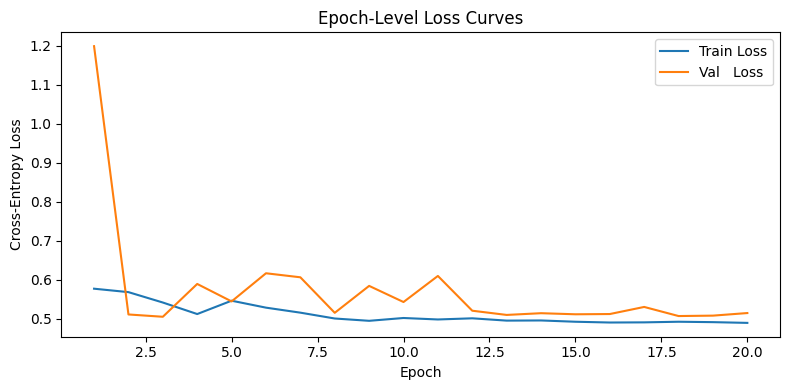

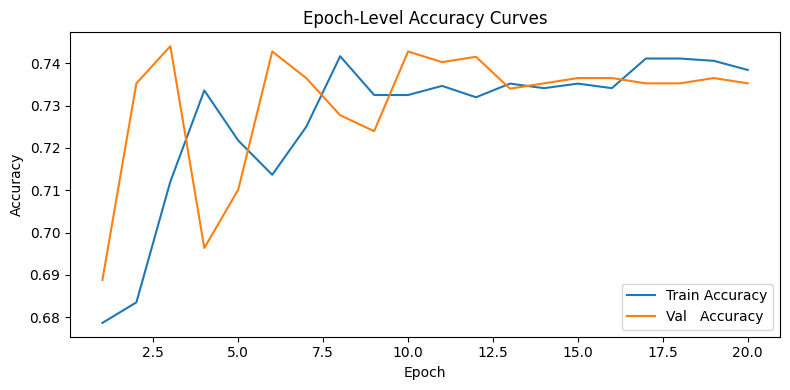

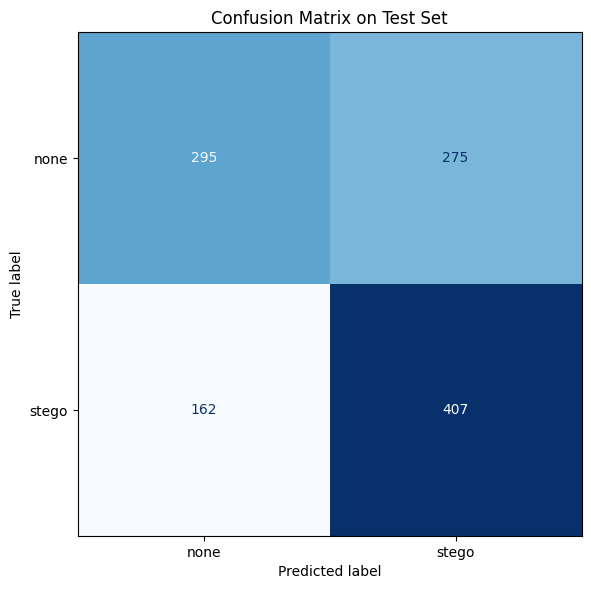

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ─── Epoch-Level Loss Curves ───────────────────────────────────────────────────
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses,   label="Val   Loss")
plt.title("Epoch-Level Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.tight_layout()
plt.show()

# ─── Epoch-Level Accuracy Curves ───────────────────────────────────────────────
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS + 1), train_accs, label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), val_accs,   label="Val   Accuracy")
plt.title("Epoch-Level Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# ─── Confusion Matrix on TEST Set ──────────────────────────────────────────────
# Load best model if not already loaded
model.load_state_dict(torch.load("best_resnet50_stego.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["none", "stego"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Weighted Ensemble Test Accuracy: 0.6962


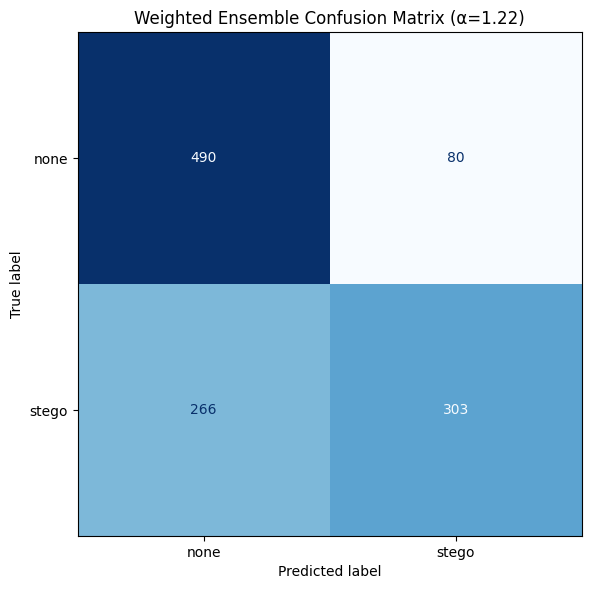

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ─── Reload both specialist models ───────────────────────────────────────────
def load_model(path):
    m = models.resnet50(pretrained=True)
    m.fc = nn.Linear(m.fc.in_features, NUM_CLASSES)
    m.load_state_dict(torch.load(path, map_location=device))
    return m.to(device).eval()

model_stego = load_model("best_resnet50_stego.pth")
model_none  = load_model("best_resnet50_none.pth")
softmax     = nn.Softmax(dim=1)

# ─── Ensemble evaluation on TEST set ────────────────────────────────────────
ensemble_preds = []
true_labels    = []
alpha = 1.22  # tweak this to give more/less weight to the stego‐model

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out_s = model_stego(imgs)
        out_n = model_none(imgs)

        # raw confidences
        conf_s = softmax(out_s)[:, 1]  # P(stego) from stego‐model
        conf_n = softmax(out_n)[:, 0]  # P(none)  from none‐model

        # weighted decision
        preds = torch.where(conf_s * alpha > conf_n,
                            torch.ones_like(conf_s),   # stego
                            torch.zeros_like(conf_s))  # none

        ensemble_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.numpy())

ensemble_preds = np.array(ensemble_preds)
true_labels    = np.array(true_labels)

# accuracy
ensemble_acc = (ensemble_preds == true_labels).mean()
print(f"Weighted Ensemble Test Accuracy: {ensemble_acc:.4f}")

# ─── Confusion matrix ───────────────────────────────────────────────────────
cm = confusion_matrix(true_labels, ensemble_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["none", "stego"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title(f"Weighted Ensemble Confusion Matrix (α={alpha})")
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import f1_score

# Define a range of alpha values to try
alphas = np.linspace(0.1, 5.0, 91)  # now tests from 0.5× up to 5.0× in 0.05 steps
best_alpha, best_f1 = None, 0.0

# Precompute all test logits once:
all_outs_s, all_outs_n, all_lbls = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        all_outs_s.append(model_stego(imgs).cpu())
        all_outs_n.append(model_none(imgs).cpu())
        all_lbls.extend(labels.numpy())

all_outs_s = torch.cat(all_outs_s)
all_outs_n = torch.cat(all_outs_n)
all_lbls   = np.array(all_lbls)

probs_s = nn.Softmax(dim=1)(all_outs_s)[:,1].numpy()  # P(stego)
probs_n = nn.Softmax(dim=1)(all_outs_n)[:,0].numpy()  # P(none)

for α in alphas:
    # weighted decision
    preds = np.where(probs_s * α > probs_n, 1, 0)
    f1 = f1_score(all_lbls, preds, average='macro')
    if f1 > best_f1:
        best_f1, best_alpha = f1, α

print(f"Best α = {best_alpha:.2f} → Macro F1 = {best_f1:.4f}")


Best α = 0.54 → Macro F1 = 0.7074


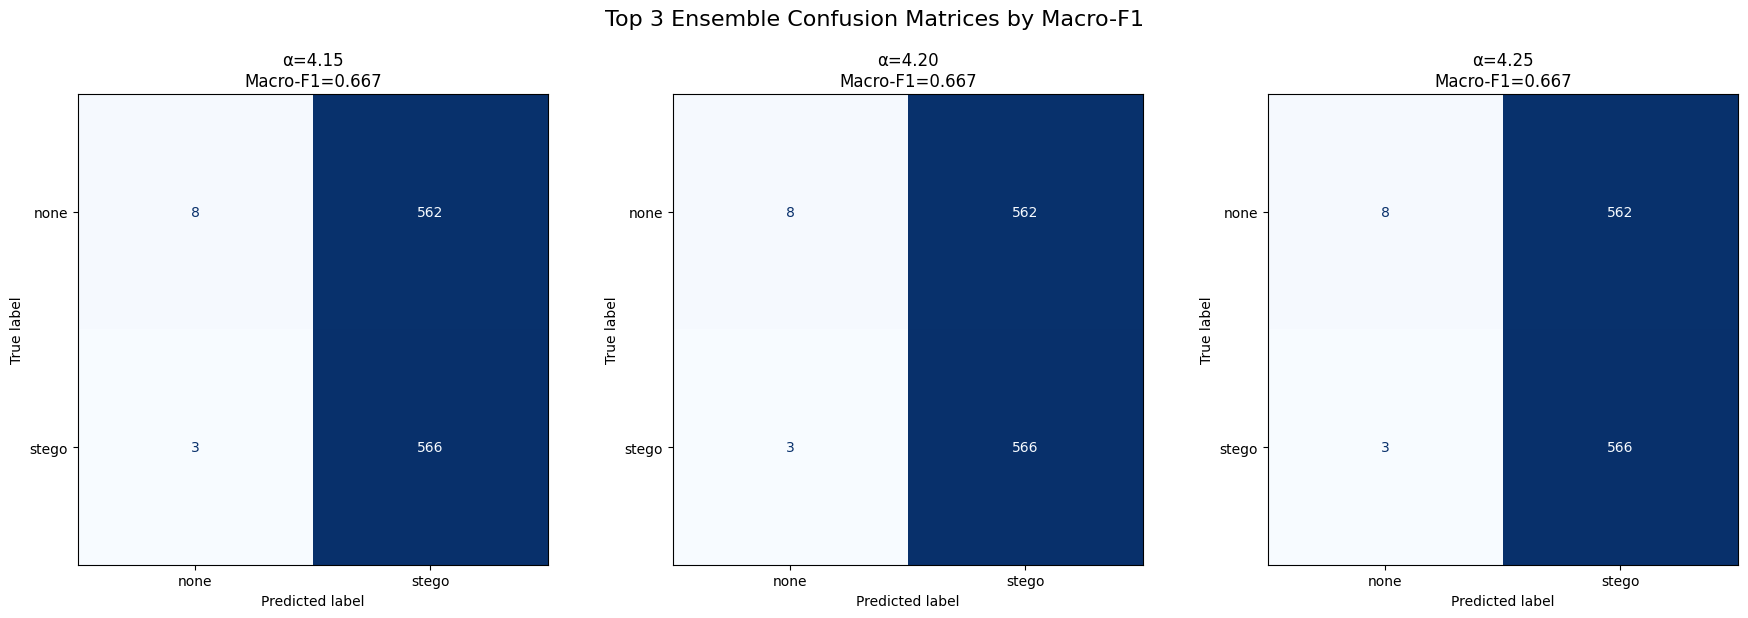

In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
device=DEVICE
# ─── A) Precompute test set probabilities ──────────────────────────────────────
all_outs_s, all_outs_n, all_lbls = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        all_outs_s.append(model_stego(imgs).cpu())
        all_outs_n.append(model_none(imgs).cpu())
        all_lbls.extend(labels.numpy())

all_outs_s = torch.cat(all_outs_s)
all_outs_n = torch.cat(all_outs_n)
all_lbls   = np.array(all_lbls)

probs_s = nn.Softmax(dim=1)(all_outs_s)[:, 1].numpy()  # P(stego)
probs_n = nn.Softmax(dim=1)(all_outs_n)[:, 0].numpy()  # P(none)

# ─── B) Grid search for best alphas ─────────────────────────────────────────────
alphas = np.linspace(0.5, 5.0, 91)  # α from 0.5 to 5.0
results = []
for alpha in alphas:
    preds = np.where(probs_s * alpha > probs_n, 1, 0)
    f1 = f1_score(all_lbls, preds, pos_label=1, average='binary')
    results.append((alpha, f1, preds))

# Sort by F1 descending and take top 3
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
top3 = results_sorted[:3]

# ─── C) Plot top 3 confusion matrices ───────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, (alpha, f1, preds) in zip(axes, top3):
    cm = confusion_matrix(all_lbls, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["none", "stego"])
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    ax.set_title(f"α={alpha:.2f}\nMacro-F1={f1:.3f}")

plt.suptitle("Top 3 Ensemble Confusion Matrices by Macro-F1", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nitinjha/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Weighted Ensemble Test Accuracy: 0.6435

Classification Report:
              precision    recall  f1-score   support

        none     0.6444    0.6421    0.6432       570
       stego     0.6427    0.6450    0.6439       569

    accuracy                         0.6435      1139
   macro avg     0.6435    0.6435    0.6435      1139
weighted avg     0.6435    0.6435    0.6435      1139



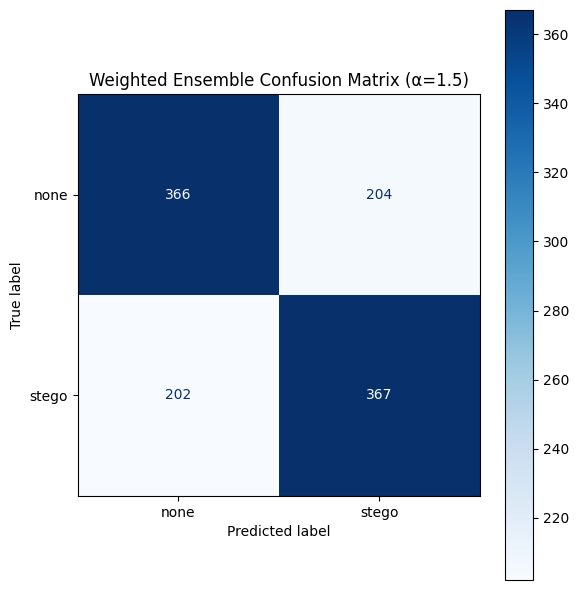

In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ─── Reload both specialist models ───────────────────────────────────────────
def load_model(path):
    m = models.resnet50(pretrained=True)
    m.fc = nn.Linear(m.fc.in_features, NUM_CLASSES)
    m.load_state_dict(torch.load(path, map_location=device))
    return m.to(device).eval()

model_stego = load_model("best_resnet50_stego.pth")
model_none  = load_model("best_resnet50_none.pth")
softmax     = nn.Softmax(dim=1)

# ─── Ensemble evaluation on TEST set ────────────────────────────────────────
ensemble_preds = []
true_labels    = []
alpha = 1.5  # tweak this to give more/less weight to the stego‐model

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out_s = model_stego(imgs)
        out_n = model_none(imgs)

        # raw confidences
        conf_s = softmax(out_s)[:, 1]  # P(stego) from stego‐model
        conf_n = softmax(out_n)[:, 0]  # P(none)  from none‐model

        # weighted decision
        preds = torch.where(conf_s * alpha > conf_n,
                            torch.ones_like(conf_s),   # stego
                            torch.zeros_like(conf_s))  # none

        ensemble_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.numpy())

ensemble_preds = np.array(ensemble_preds)
true_labels    = np.array(true_labels)

# accuracy
ensemble_acc = (ensemble_preds == true_labels).mean()
print(f"Weighted Ensemble Test Accuracy: {ensemble_acc:.4f}")
from sklearn.metrics import classification_report

# ─── After your confusion matrix ───────────────────────────────────────────────
print("\nClassification Report:")
report = classification_report(true_labels, ensemble_preds,
                               target_names=["none", "stego"],
                               digits=4)
print(report)

# ─── Confusion matrix ───────────────────────────────────────────────────────
cm = confusion_matrix(true_labels, ensemble_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["none", "stego"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues")
plt.title(f"Weighted Ensemble Confusion Matrix (α={alpha})")
plt.tight_layout()
plt.show()